# PLAYER MARKET VALUE PREDICTION SYSTEM

## Importing Libraries 

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import corr, col, split
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

## Starting spark session 

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PlayerMarketValuePrediction") \
    .config("spark.executor.memory", "256g") \
    .getOrCreate()

df = spark.read.csv("dataset.csv", header=True, inferSchema=True)

## Exploratory Data Analysis and Data Preprocessing

In [2]:
df.printSchema()

root
 |-- player_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- fifa_version: integer (nullable = true)
 |-- fifa_update: integer (nullable = true)
 |-- fifa_update_date: date (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- league_id: integer (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_team_id: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loane

In [3]:
num_rows = df.count()
num_columns = len(df.columns)

num_features = len(df.columns) - 1

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")
print(f"Number of features: {num_features}")


Number of rows: 10003590
Number of columns: 110
Number of features: 109


In [4]:
irrelevant_columns = ['player_id', 'player_url', 'fifa_version', 'fifa_update', 'fifa_update_date', 'dob', 'player_face_url']

df = df.drop(*irrelevant_columns)

In [5]:
num_rows = df.count()
num_columns = len(df.columns)
print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")

Shape of the DataFrame: (10003590, 103)


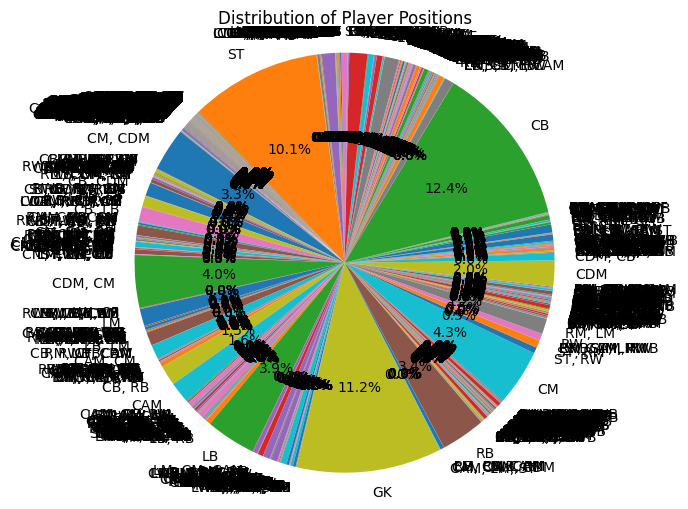

In [6]:
import matplotlib.pyplot as plt

position_counts = df.groupBy('player_positions').count().collect()

positions = [row['player_positions'] for row in position_counts]
counts = [row['count'] for row in position_counts]

plt.figure(figsize=(8, 6))
plt.pie(counts, labels=positions, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Player Positions')
plt.axis('equal')
plt.show()


In [7]:
market_value_columns = ['overall', 'potential', 'value_eur']

df.select(market_value_columns).show()


+-------+---------+---------+
|overall|potential|value_eur|
+-------+---------+---------+
|     91|       91| 54000000|
|     91|       91| 64000000|
|     91|       91| 84000000|
|     91|       91|107500000|
|     91|       95|190500000|
|     90|       91| 90000000|
|     90|       90|115500000|
|     89|       89| 11500000|
|     89|       89| 99500000|
|     89|       89| 86000000|
|     89|       90| 79000000|
|     89|       89|105500000|
|     89|       89| 84500000|
|     89|       89|101000000|
|     89|       91| 88000000|
|     89|       90|105500000|
|     89|       90| 79000000|
|     89|       94|160000000|
|     88|       88| 31000000|
|     88|       88| 29000000|
+-------+---------+---------+
only showing top 20 rows



## Correlation 

In [8]:
from pyspark.sql.functions import corr, col

numerical_columns = [column for column in df.columns if df.select(column).dtypes[0][1] in ['int', 'bigint', 'float', 'double'] and column != 'value_eur']

correlations = {}
for column in numerical_columns:
    correlation = df.select(corr('value_eur', column)).first()[0]
    correlations[column] = correlation

sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top correlated columns with market value:")
for column, correlation in sorted_correlations:
    print(f"{column}: {correlation}")


Top correlated columns with market value:
release_clause_eur: 0.9929597350426682
wage_eur: 0.7837627476844449
international_reputation: 0.604863025823549
overall: 0.575067828870559
potential: 0.5386675767736293
movement_reactions: 0.49673214141534805
passing: 0.40249622622217907
mentality_composure: 0.39760140996194077
dribbling: 0.3918462077656854
mentality_vision: 0.3247556743290511
shooting: 0.3107299741421666
attacking_short_passing: 0.29714063128015944
skill_long_passing: 0.2774264873649916
skill_ball_control: 0.27620187608675323
power_shot_power: 0.26947194907981736
skill_curve: 0.25749347248951693
attacking_volleys: 0.25170587485918233
skill_moves: 0.2496889954336218
skill_dribbling: 0.24419899057023936
power_long_shots: 0.2440384058883519
mentality_positioning: 0.23331928401635116
attacking_finishing: 0.22853323935311096
skill_fk_accuracy: 0.22752208430426504
attacking_crossing: 0.2260734930655791
physic: 0.21560568787933693
goalkeeping_speed: 0.2094374772781404
mentality_penal

In [9]:
print("Top 5 correlated columns with market value:")
for column, correlation in sorted_correlations[:5]:
    print(f"{column}: {correlation}")

Top 5 correlated columns with market value:
release_clause_eur: 0.9929597350426682
wage_eur: 0.7837627476844449
international_reputation: 0.604863025823549
overall: 0.575067828870559
potential: 0.5386675767736293


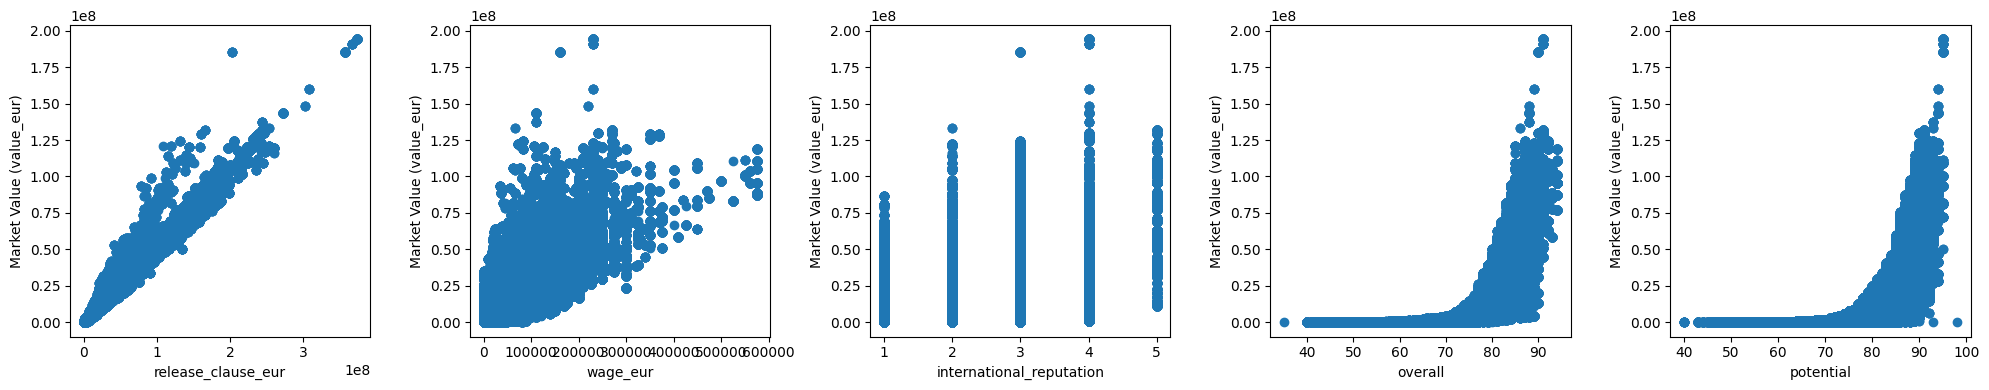

In [10]:
    import matplotlib.pyplot as plt
    
    top_correlated_columns = [column for column, _ in sorted_correlations[:5]]
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    
    for i, column in enumerate(top_correlated_columns):
        axes[i].scatter(df.select(column).collect(), df.select('value_eur').collect())
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Market Value (value_eur)')
    
    plt.tight_layout()
    plt.show()


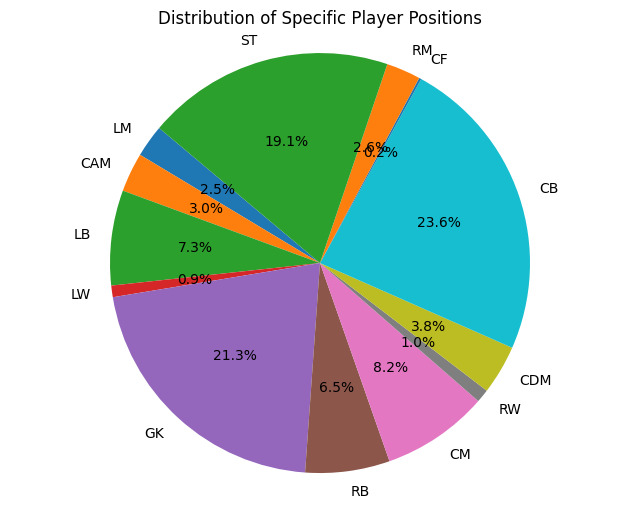

In [11]:
import matplotlib.pyplot as plt

specific_positions = ['GK', 'LB', 'CB', 'RB', 'CDM', 'CM','LM' , 'RM', 'CAM', 'LW', 'RW', 'ST', 'CF']
filtered_df = df.filter(df['player_positions'].isin(specific_positions))

position_counts = filtered_df.groupBy('player_positions').count().collect()

# Extract position names and counts
positions = [row['player_positions'] for row in position_counts]
counts = [row['count'] for row in position_counts]

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=positions, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Specific Player Positions')
plt.axis('equal')
plt.show()

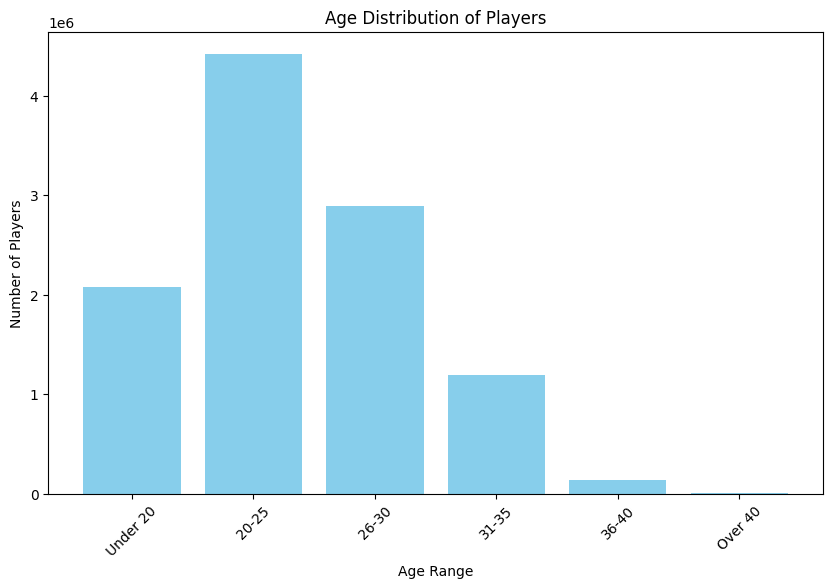

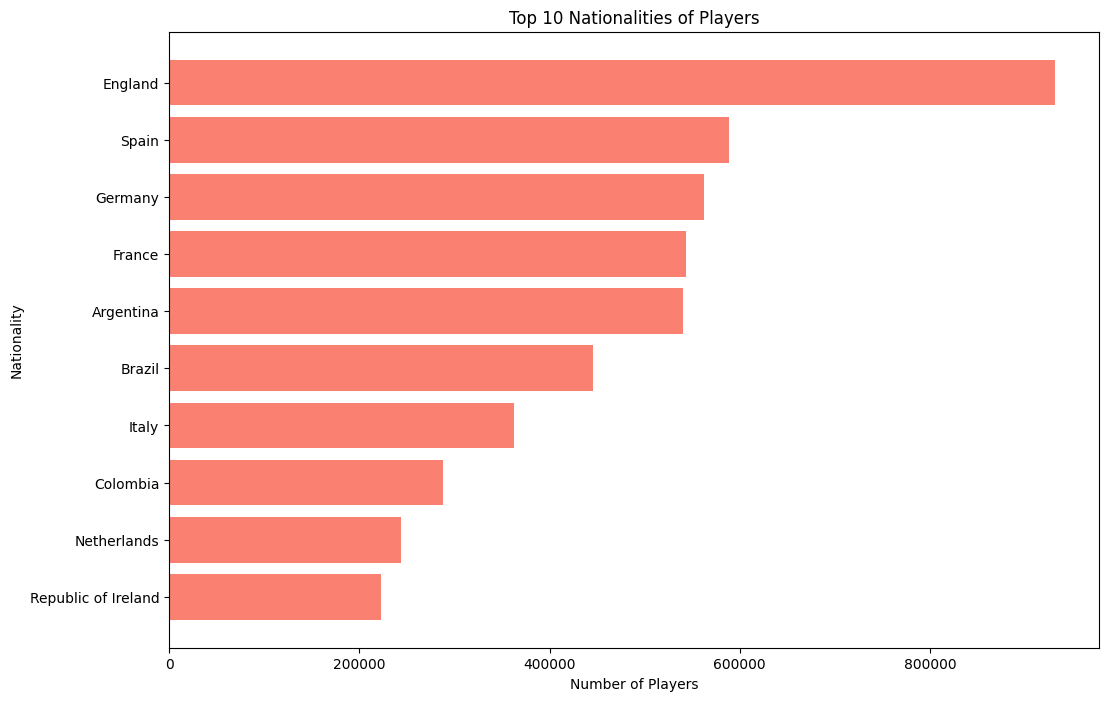

In [12]:
import matplotlib.pyplot as plt

age_ranges = [
    ('Under 20', (0, 20)),
    ('20-25', (20, 25)),
    ('26-30', (26, 30)),
    ('31-35', (31, 35)),
    ('36-40', (36, 40)),
    ('Over 40', (41, 100))
]

age_counts = []
for label, (start, end) in age_ranges:
    filtered_df = df.filter((df['age'] >= start) & (df['age'] <= end))
    count = filtered_df.count()
    age_counts.append((label, count))

plt.figure(figsize=(10, 6))
ages, counts = zip(*age_counts)
plt.bar(ages, counts, color='skyblue')
plt.xlabel('Age Range')
plt.ylabel('Number of Players')
plt.title('Age Distribution of Players')
plt.xticks(rotation=45)
plt.show()

nationality_counts = df.groupBy('nationality_name').count().collect()

nationality_counts.sort(key=lambda x: x['count'], reverse=True)

nationalities = [row['nationality_name'] for row in nationality_counts[:10]]  
counts = [row['count'] for row in nationality_counts[:10]]  

plt.figure(figsize=(12, 8))
plt.barh(nationalities, counts, color='salmon')
plt.xlabel('Number of Players')
plt.ylabel('Nationality')
plt.title('Top 10 Nationalities of Players')
plt.gca().invert_yaxis()
plt.show()


![alt text](filtering.jpg)

In [13]:
spark.stop()

## Using the filtered dataset in a new spark session


In [14]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("model") \
    .config("spark.executor.memory", "256g") \
    .getOrCreate()

df = spark.read.csv("filtered_data.csv", header=True, inferSchema=True)

In [15]:
df.printSchema()

root
 |-- short_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- league_name: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- nationality_name: string (nullable = true)
 |-- nation_position: string (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- body_type: string (nullable = true)
 |-- release_clause_eur: integer (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physical: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = t

In [16]:
num_rows = df.count()
num_columns = len(df.columns)

num_features = len(df.columns) - 1

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")
print(f"Number of features: {num_features}")

Number of rows: 1048574
Number of columns: 69
Number of features: 68


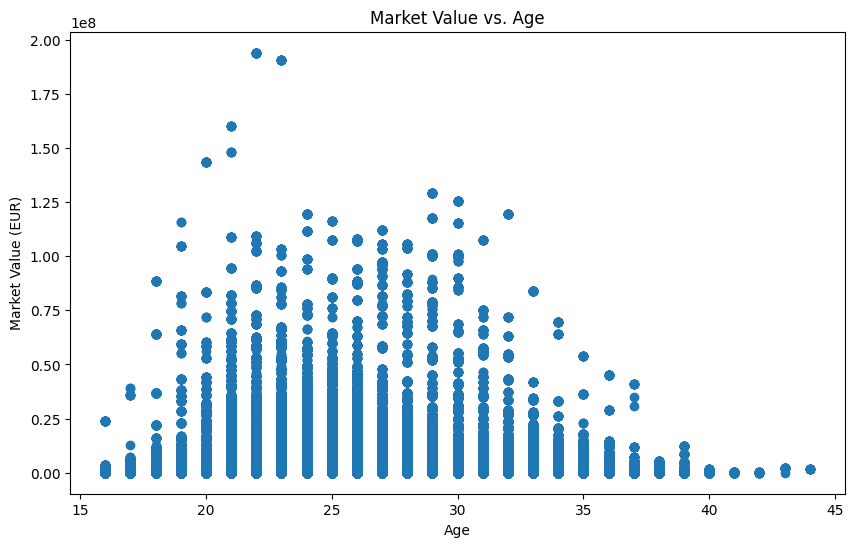

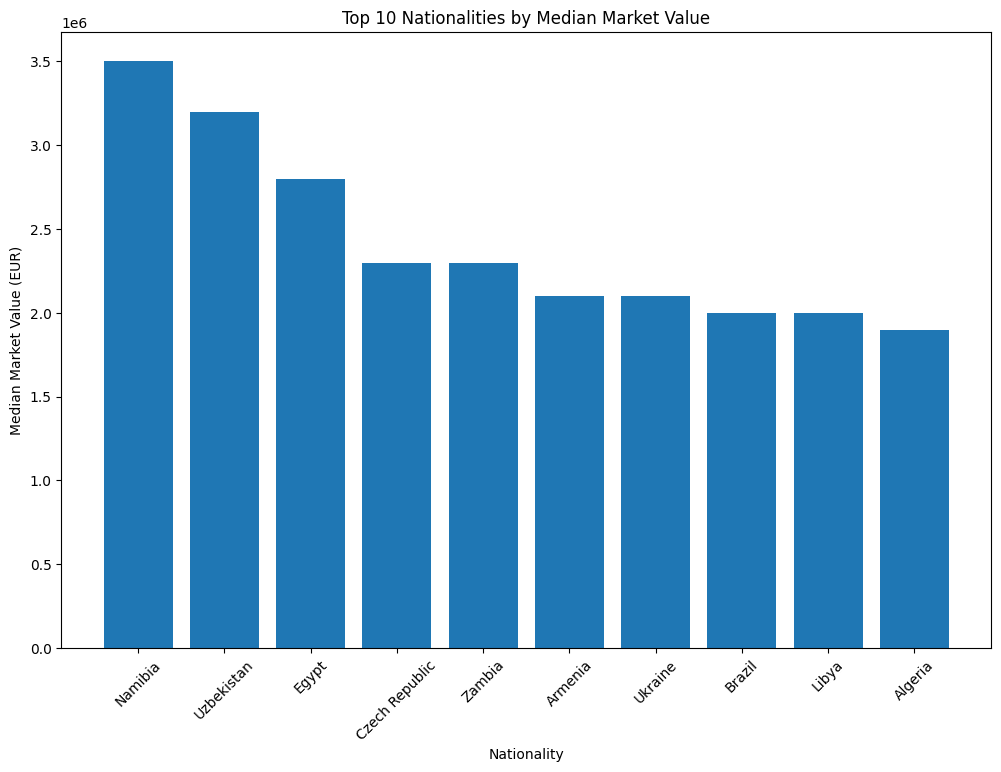

In [17]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

age_value_df = df.select('age', 'value_eur').toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(age_value_df['age'], age_value_df['value_eur'])
plt.title('Market Value vs. Age')
plt.xlabel('Age')
plt.ylabel('Market Value (EUR)')
plt.show()

import matplotlib.pyplot as plt

nationality_value_median = df.groupBy('nationality_name').agg({'value_eur': 'median'}).withColumnRenamed('median(value_eur)', 'median_value_eur')

top_n = 10
top_nationalities = nationality_value_median.orderBy('median_value_eur', ascending=False).limit(top_n).toPandas()

plt.figure(figsize=(12, 8))
plt.bar(top_nationalities['nationality_name'], top_nationalities['median_value_eur'])
plt.title(f'Top {top_n} Nationalities by Median Market Value')
plt.xlabel('Nationality')
plt.ylabel('Median Market Value (EUR)')
plt.xticks(rotation=45)
plt.show()



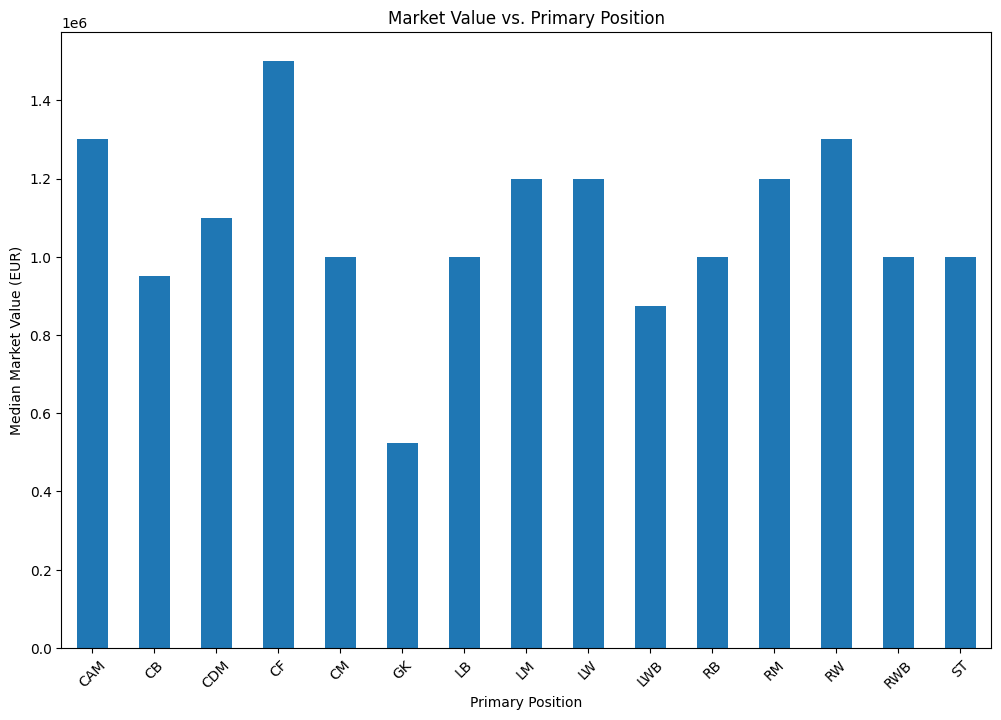

In [18]:
from pyspark.sql.functions import split, col

df = df.withColumn('primary_position', split(col('player_positions'), ',')[0])

position_value_df = df.select('primary_position', 'value_eur').toPandas()
plt.figure(figsize=(12, 8))
position_value_df.groupby('primary_position')['value_eur'].median().plot(kind='bar')
plt.title('Market Value vs. Primary Position')
plt.xlabel('Primary Position')
plt.ylabel('Median Market Value (EUR)')
plt.xticks(rotation=45)
plt.show()


In [19]:
from pyspark.sql.functions import avg

nationality_avg_value = df.groupby('nationality_name') \
    .agg(avg('value_eur').alias('avg_value_eur_nationality'))

league_avg_value = df.groupby('league_name') \
    .agg(avg('value_eur').alias('avg_value_eur_league'))

top_5_nationalities = nationality_avg_value.orderBy('avg_value_eur_nationality', ascending=False).limit(5)
top_5_leagues = league_avg_value.orderBy('avg_value_eur_league', ascending=False).limit(5)

print("Top 5 Nationalities with Highest Average Value:")
top_5_nationalities.show()

print("Top 5 Leagues with Highest Average Value:")
top_5_leagues.show()

Top 5 Nationalities with Highest Average Value:
+--------------------+-------------------------+
|    nationality_name|avg_value_eur_nationality|
+--------------------+-------------------------+
|               Egypt|     1.2105111111111112E7|
|Central African R...|     1.0161538461538462E7|
|               Libya|        8198134.328358209|
|            Portugal|        6605322.014606848|
|             Armenia|        5827380.952380952|
+--------------------+-------------------------+

Top 5 Leagues with Highest Average Value:
+--------------+--------------------+
|   league_name|avg_value_eur_league|
+--------------+--------------------+
|Premier League|1.2511453065223476E7|
|       La Liga|1.1532616887069108E7|
|       Serie A|   7579350.367532061|
|       Ligue 1|   7250871.063909074|
|    Bundesliga|   6296445.509176547|
+--------------+--------------------+



In [20]:
from pyspark.sql.functions import corr, col

numerical_columns = [column for column in df.columns if df.select(column).dtypes[0][1] in ['int', 'bigint', 'float', 'double'] and column != 'value_eur']

correlations = {}
for column in numerical_columns:
    correlation = df.select(corr('value_eur', column)).first()[0]
    correlations[column] = correlation

sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top correlated columns with market value:")
for column, correlation in sorted_correlations:
    print(f"{column}: {correlation}")


Top correlated columns with market value:
release_clause_eur: 0.9953233037263928
wage_eur: 0.8160124426371295
international_reputation: 0.5913515735044672
overall: 0.5594574612463978
potential: 0.5328943921824809
movement_reactions: 0.4998189769978091
dribbling: 0.40877574597959
passing: 0.40817829937956746
mentality_composure: 0.39234359660133517
mentality_vision: 0.33017997170284713
power_shot_power: 0.3034938608449455
attacking_short_passing: 0.3027144868431116
shooting: 0.2902962401554183
skill_long_passing: 0.2882992326747768
skill_ball_control: 0.27384053215073045
skill_curve: 0.2516369618799334
skill_dribbling: 0.2418466445175153
attacking_volleys: 0.23576987614414185
power_long_shots: 0.22934107400740947
attacking_crossing: 0.22786891620163466
mentality_positioning: 0.2229538118354699
physical: 0.21955944095733007
attacking_finishing: 0.2189233786287001
goalkeeping_speed: 0.2176292207025567
skill_fk_accuracy: 0.21065477297364815
power_stamina: 0.20120031051008339
mentality_pena

## Player position encoding

In [21]:
from pyspark.sql import functions as F

major_positions = ['GK', 'LWB', 'LB', 'CB', 'RWB', 'RB', 'CDM', 'CM', 'CAM', 'LM', 'RM', 'LW', 'RW', 'CF', 'ST']

df_encoded = df.withColumn('primary_position', F.split(df['player_positions'], ',').getItem(0))

for position in major_positions:
    df_encoded = df_encoded.withColumn(position.lower(), F.when(F.array_contains(F.split(df['player_positions'], ','), position), 1).otherwise(0))

df_encoded = df_encoded.drop('player_positions')

df_encoded.show()


+--------------+-------+---------+---------+--------+----+---------+--------------+-------------------+-------------+----------------+---------------+------------------------+----------------+------------------+----+--------+-------+---------+---------+--------+------------------+-------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+---+---+---+---+---+---+---+---+---+---+---+---+---+----------------+---+

## Data selection and transformation

In [22]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

selected_columns = ['release_clause_eur', 'wage_eur', 'international_reputation', 'overall', 'potential', 'value_eur']
data = df.select(selected_columns)

data = data.dropna()

assembler = VectorAssembler(inputCols=['release_clause_eur', 'wage_eur', 'international_reputation', 'overall', 'potential'],
                            outputCol='features')
data = assembler.transform(data)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)



Linear Regression RMSE: 761708.2417341389
Random Forest RMSE: 2032001.6399402905
Gradient Boosted Tree RMSE: 1070243.3048082022


## Splitting data and fitting ML models 

In [ ]:
train_data, test_data = data.randomSplit([0.80, 0.20], seed=42)

lr = LinearRegression(featuresCol='scaled_features', labelCol='value_eur')
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='value_eur')
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='value_eur')

lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
gbt_model = gbt.fit(train_data)

lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

## Evaluating models

In [ ]:
evaluator = RegressionEvaluator(labelCol='value_eur', predictionCol='prediction', metricName='rmse')

lr_rmse = evaluator.evaluate(lr_predictions)
rf_rmse = evaluator.evaluate(rf_predictions)
gbt_rmse = evaluator.evaluate(gbt_predictions)

print("Linear Regression RMSE:", lr_rmse)
print("Random Forest RMSE:", rf_rmse)
print("Gradient Boosted Tree RMSE:", gbt_rmse)

## Using sklearn as an alternative

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data_pd = df[selected_columns].toPandas()

data_pd = data_pd.dropna()

X = data_pd.drop('value_eur', axis=1)
y = data_pd['value_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
rf = RandomForestRegressor()
gbt = GradientBoostingRegressor()

lr.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)
gbt.fit(X_train_scaled, y_train)

lr_predictions = lr.predict(X_test_scaled)
rf_predictions = rf.predict(X_test_scaled)
gbt_predictions = gbt.predict(X_test_scaled)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
gbt_rmse = np.sqrt(mean_squared_error(y_test, gbt_predictions))

print("Linear Regression RMSE:", lr_rmse)
print("Random Forest RMSE:", rf_rmse)
print("Gradient Boosted Tree RMSE:", gbt_rmse)


Linear Regression RMSE: 742621.182251326
Random Forest RMSE: 65977.03908110142
Gradient Boosted Tree RMSE: 527012.940261484


## Prediciting using Linear regression

In [24]:
release_clause = float(input("Enter release clause (in EUR): "))
wage = float(input("Enter wage (in EUR): "))
international_reputation = float(input("Enter international reputation: "))
overall = float(input("Enter overall rating: "))
potential = float(input("Enter potential rating: "))
age = float(input("Enter player's age :"))
position = input("Enter player's position (e.g., GK, LWB, LB, CB, etc.): ")

encoded_position = position_encoder.transform([[position]])[0][0]
input_features = np.array([[release_clause, wage, international_reputation, overall, potential]])
input_features_scaled = scaler.transform(input_features)

predicted_value = lr.predict(input_features_scaled)

print("Predicted value (in EUR):", predicted_value[0])

Enter release clause (in EUR):  200000000
Enter wage (in EUR):  150000
Enter international reputation:  5
Enter overall rating:  89
Enter potential rating:  94


Predicted value (in EUR): 103166010.52679962


C:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Prediciting using Random Forests

In [ ]:
release_clause = float(input("Enter release clause (in EUR): "))
wage = float(input("Enter wage (in EUR): "))
international_reputation = float(input("Enter international reputation: "))
overall = float(input("Enter overall rating: "))
potential = float(input("Enter potential rating: "))
age = float(input("Enter player's age :"))
position = input("Enter player's position (e.g., GK, LWB, LB, CB, etc.): ")

encoded_position = position_encoder.transform([[position]])[0][0]
input_features = np.array([[release_clause, wage, international_reputation, overall, potential]])
input_features_scaled = scaler.transform(input_features)

predicted_value = rf.predict(input_features_scaled)

print("Predicted value (in EUR):", predicted_value[0])